In [2]:
from datetime import datetime, timedelta
import logging

from src.data.get_data import YahooFinanceAPI as yfapi
from src.models_service.models_service import TensorflowModelService as TFModelService
from src.common.plots import Visualize as V
from src.common.logs import setup_logging

logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

config = {
    'tickers': ['MSFT','VGT'],
    'model_name': 'VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17'
}

In [6]:
# Get the stock data
selected_ticker = config['tickers'][1] # VGT

today = datetime.today().strftime('%Y-%m-%d')
stock_data_YTD = yfapi.get_daily_data(selected_ticker, start_date='2023-01-01', end_date=today)
stock_data_df = stock_data_YTD[stock_data_YTD.index > '2023-01-01']
stock_data_df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-16,423.609985,429.649994,423.609985,427.899994,427.899994,260000
2023-10-17,422.010010,428.450012,419.540009,426.070007,426.070007,397900
2023-10-18,422.609985,425.440002,418.929993,420.230011,420.230011,318300
2023-10-19,422.250000,424.559998,416.649994,417.239990,417.239990,435400
2023-10-20,416.730011,417.329987,409.410004,409.880005,409.880005,576700


2023-10-22 03:59:20 - __main__ - INFO - Model loaded from: /workspaces/P7-Trading-Bot/models_trained/VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17.keras
2023-10-22 03:59:20 - __main__ - INFO - Model loaded from: /workspaces/P7-Trading-Bot/models_trained/VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17.keras
2023-10-22 03:59:20 - __main__ - INFO - Scalers loaded: /workspaces/P7-Trading-Bot/models_trained/VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17_scalers.pkl
2023-10-22 03:59:20 - __main__ - INFO - Scalers loaded: /workspaces/P7-Trading-Bot/models_trained/VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17_scalers.pkl


183/183 [==============================] - 2s 6ms/step


2023-10-22 03:59:22.196620: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8534717355666677470
2023-10-22 03:59:22 - src.common.plots - INFO - Plot "Predictions VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17-VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17.png" saved to "/workspaces/P7-Trading-Bot/figures/Predictions VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17-VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17.png"


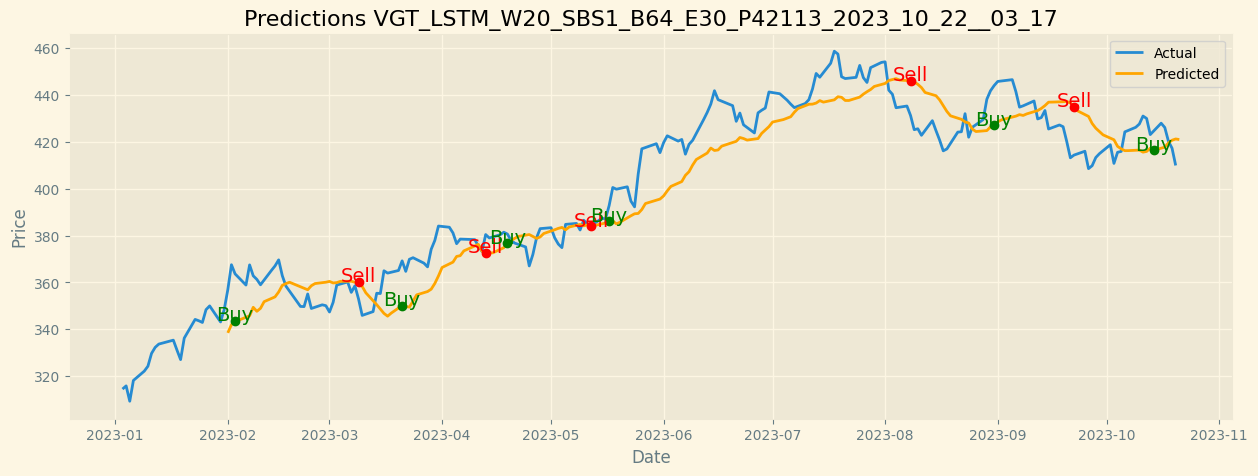

'/workspaces/P7-Trading-Bot/figures/Predictions VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17-VGT_LSTM_W20_SBS1_B64_E30_P42113_2023_10_22__03_17.png'

In [30]:
# Prepare the data for the model
df_test_X = stock_data_df[['Adj Close', 'Volume']]
df_test_y = stock_data_df['Adj Close']


# Calculate predictions and plot Buy and Sell signals
model_name = config['model_name']

model = TFModelService.load_model(model_name=model_name, logger=logger)
scalers = TFModelService.load_scalers(model_name=model_name, logger=logger)
window_size = TFModelService.get_window_size_from_model_name(model._name)

results = TFModelService.model_forecast(model=model, 
                                        df=df_test_X,
                                        window_size=window_size,
                                        scalers=scalers,
                                        verbose=False)

shifted_for_results = df_test_y.index[window_size-1:].shift(1, freq='D')


V.plot_series(  
                # x=(range(len(df_test_y))[-last_n_days:], range(len(df_test_y.index))[window_size-1:][-last_n_days:]), 
                # y=(df_test_y[-last_n_days:], results[-last_n_days:]),
                x=(df_test_y.index, shifted_for_results), 
                y=(df_test_y, results),
                model_name=model._name,
                signal = True,
                title=f'Predictions {model._name}',
                xlabel='Date',
                ylabel='Price',
                legend=['Actual', 'Predicted'],
                show=True)